In [1]:
import pandas as pd
import sys
import glob
import errno
import numpy as np
from nltk.corpus import stopwords
import re
import nltk.data
import nltk
import os
from sklearn.metrics import log_loss
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from tqdm import tqdm
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalAveragePooling1D,Concatenate,Lambda,Input,GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D,TimeDistributed
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from sklearn.linear_model import SGDClassifier as sgd
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import string

# 기본 전처리

In [2]:
trn = pd.read_csv('./train.csv', encoding = 'utf-8')
tst = pd.read_csv('./test_x.csv', encoding = 'utf-8')

/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-pac

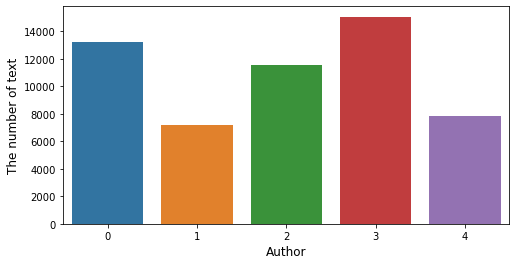

In [3]:
trn_graph = trn['author'].value_counts()
color = sns.color_palette()

plt.figure(figsize=(8,4))
sns.barplot(trn_graph.index, trn_graph.values)
plt.ylabel('The number of text', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.show()

/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(

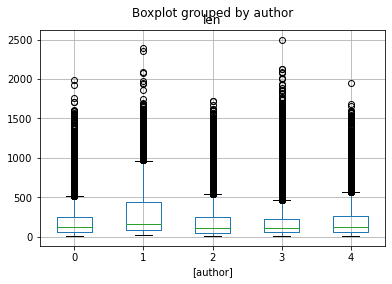

In [4]:
#단순히 길이로만 boxplot 형태 확인(이상치를 단순히 길이로 잡는건 잘못된 생각)
trn['len'] = trn['text'].apply(len)
trn.boxplot(column = ["len"], by = ["author"])
plt.show()
trn = trn.drop(['len'], axis=1)

In [5]:
#문장으로부터 pure word를 추출 및 단어의 개수
def clean(trn,tst):
    trn['words'] = [re.sub("[^a-zA-Z]"," ", data).lower().split() for data in trn['text']]
    tst['words'] = [re.sub("[^a-zA-Z]"," ", data).lower().split() for data in tst['text']]
    return trn,tst
trn, tst = clean(trn, tst)

trn["num_words"] = trn["text"].apply(lambda x: len(str(x).split()))
tst["num_words"] = tst["text"].apply(lambda x: len(str(x).split()))

In [6]:
#각 저자마다 좋아하는 구두점의 개수와 비율을 가진 피쳐 생성(string 내장함수와 직접 선언)

trn["num_punctuations"] = trn['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
tst["num_punctuations"] = tst['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

punctuations = [{"id":1,"p":"[;:]"},{"id":2,"p":"[,.]"},{"id":3,"p":"[?]"},{"id":4,"p":"[\']"},{"id":5,"p":"[\"]"},{"id":6,"p":"[;:,.?\'\"]"}]
for p in punctuations:
    punctuation = p["p"]
    temp_trn =  [ sentence.split() for sentence in trn['text'] ]
    trn['punc_'+str(p["id"])] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in temp_trn]    
    temp_tst =  [ sentence.split() for sentence in tst['text'] ]
    tst['punc_'+str(p["id"])] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in temp_tst]


In [7]:
#각 문장의 stopword 개수와 비율을 추출
#0으로 나뉘어지는 경우는 전체 길이에 각각 1을 더해서 해결
trn["num_stopwords"] = trn["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
tst["num_stopwords"] = tst["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))

stop_trn = [x for x in trn['words']]
trn['stop_word'] = [len([word for word in sentence if word in stopwords.words('english')])*100.0/(len(sentence)+1) for sentence in stop_trn]

stop_tst = [x for x in tst['words']]
tst['stop_word'] = [len([word for word in sentence if word in stopwords.words('english')])*100.0/(len(sentence)+1) for sentence in stop_tst] 


In [8]:
## 그 외 특정단어, 대문자 단어 등의 개수를 추출

trn["num_unique_words"] = trn["text"].apply(lambda x: len(set(str(x).split())))
tst["num_unique_words"] = tst["text"].apply(lambda x: len(set(str(x).split())))

trn["num_chars"] = trn["text"].apply(lambda x: len(str(x)))
tst["num_chars"] = tst["text"].apply(lambda x: len(str(x)))

trn["num_words_upper"] = trn["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
tst["num_words_upper"] = tst["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

trn["num_words_title"] = trn["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
tst["num_words_title"] = tst["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

trn["mean_word_len"] = trn["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
tst["mean_word_len"] = tst["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [9]:
trn.head(5)

,index,text,author,words,num_words,num_punctuations,punc_1,punc_2,punc_3,punc_4,punc_5,punc_6,num_stopwords,stop_word,num_unique_words,num_chars,num_words_upper,num_words_title,mean_word_len
0,0,"He was almost choking. There was so much, so m...",3,"[he, was, almost, choking, there, was, so, muc...",46,8,2.173913,15.217391,0.000000,0.000000,0.0,17.391304,25,55.319149,39,240,0,4,4.239130
1,1,"“Your sister asked for it, I suppose?”",2,"[your, sister, asked, for, it, i, suppose]",7,2,0.000000,14.285714,14.285714,0.000000,0.0,28.571429,2,50.000000,7,38,1,2,4.571429
2,2,"She was engaged one day as she walked, in per...",1,"[she, was, engaged, one, day, as, she, walked,...",57,9,1.754386,14.035088,0.000000,0.000000,0.0,15.789474,26,49.152542,50,320,0,4,4.614035
3,3,"The captain was in the porch, keeping himself ...",4,"[the, captain, was, in, the, porch, keeping, h...",58,18,3.448276,25.862069,0.000000,1.724138,0.0,31.034483,26,46.666667,49,319,0,7,4.517241
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,"[have, mercy, gentlemen, odin, flung, up, his,...",39,13,2.564103,17.948718,0.000000,0.000000,0.0,20.512821,16,54.761905,36,228,0,4,4.871795


In [10]:
tst.head(5)

,index,text,words,num_words,num_punctuations,punc_1,punc_2,punc_3,punc_4,punc_5,punc_6,num_stopwords,stop_word,num_unique_words,num_chars,num_words_upper,num_words_title,mean_word_len
0,0,“Not at all. I think she is one of the most ch...,"[not, at, all, i, think, she, is, one, of, the...",89,9,1.123596,8.988764,0.000000,0.0,0.000000,10.112360,49,58.888889,68,456,5,9,4.134831
1,1,"""No,"" replied he, with sudden consciousness, ""...","[no, replied, he, with, sudden, consciousness,...",43,20,2.325581,20.930233,0.000000,0.0,6.976744,25.581395,21,65.957447,36,221,5,5,4.162791
2,2,As the lady had stated her intention of scream...,"[as, the, lady, had, stated, her, intention, o...",64,10,3.125000,12.500000,0.000000,0.0,0.000000,15.625000,32,50.769231,55,375,0,2,4.875000
3,3,“And then suddenly in the silence I heard a so...,"[and, then, suddenly, in, the, silence, i, hea...",240,28,0.416667,10.833333,0.416667,0.0,0.000000,11.666667,121,53.526971,150,1218,11,21,4.079167
4,4,His conviction remained unchanged. So far as I...,"[his, conviction, remained, unchanged, so, far...",91,13,0.000000,9.890110,0.000000,0.0,0.000000,9.890110,44,54.255319,71,510,4,8,4.615385


# Stack Features

In [11]:
X_train = trn
X_test = tst
# 종속변수 수치화
Y_train = LabelEncoder().fit_transform(X_train['author'])

In [12]:
# Multinomial Naive Bayes(MNB)
# Word base, Character base인 TFIDF와 Counts를 통해 feature를 생성

def MNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def TFIDF_MNB(X_train,X_test,Y_train):
    #ngram = 2
    #최대 2개로 묶는 것이 제일 적은 loss를 보여줌. (정우)
    tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
    svd_tfidf = tfidf_vec.fit_transform(X_train['text'].values.tolist())
    train_tfidf = tfidf_vec.transform(X_train['text'].values.tolist())
    test_tfidf = tfidf_vec.transform(X_test['text'].values.tolist())
    
    #학습 전 특이값분해를 통해 새 피쳐 생성
    n_comp = 20
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(svd_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

    train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
    test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
    X_train = pd.concat([X_train, train_svd], axis=1)
    X_test= pd.concat([X_test, test_svd], axis=1)

    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([X_train.shape[0], 5])
    kf = model_selection.KFold(n_splits=8, shuffle=True, random_state=2020)
    #아까 말한 kfold 8번 & random_state 2020 밑에도 다 봐바(정우)
    for trn_index, tst_index in kf.split(X_train):
        trn_X, tst_X = train_tfidf[trn_index], train_tfidf[tst_index]
        trn_y, tst_y = Y_train[trn_index], Y_train[tst_index]
        pred_val_y, pred_test_y, model = MNB(trn_X, trn_y, tst_X, tst_y, test_tfidf)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        cv_scores.append(metrics.log_loss(tst_y, pred_val_y))
    print("Mean cv score : ", np.mean(cv_scores))
    pred_full_test = pred_full_test / 8.
    return pred_train,pred_full_test

pred_train,pred_test = TFIDF_MNB(X_train,X_test,Y_train)

X_train["tfidf_words_nb_cvec_0"] = pred_train[:,0]
X_train["tfidf_words_nb_cvec_1"] = pred_train[:,1]
X_train["tfidf_words_nb_cvec_2"] = pred_train[:,2]
X_train["tfidf_words_nb_cvec_3"] = pred_train[:,3]
X_train["tfidf_words_nb_cvec_4"] = pred_train[:,4]
X_test["tfidf_words_nb_cvec_0"] = pred_test[:,0]
X_test["tfidf_words_nb_cvec_1"] = pred_test[:,1]
X_test["tfidf_words_nb_cvec_2"] = pred_test[:,2]
X_test["tfidf_words_nb_cvec_3"] = pred_test[:,3]
X_test["tfidf_words_nb_cvec_4"] = pred_test[:,4]

Mean cv score :  1.0898864911765824


In [13]:
# TFIDF Char

def TFIDF_MNB(X_train,X_test,Y_train):
    tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2),analyzer='char')
    svd_tfidf = tfidf_vec.fit_transform(X_train['text'].values.tolist())
    train_tfidf = tfidf_vec.transform(X_train['text'].values.tolist())
    test_tfidf = tfidf_vec.transform(X_test['text'].values.tolist())
    
    n_comp = 20
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(svd_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

    train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
    test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
    X_train = pd.concat([X_train, train_svd], axis=1)
    X_test= pd.concat([X_test, test_svd], axis=1)

    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([X_train.shape[0], 5])
    kf = model_selection.KFold(n_splits=8, shuffle=True, random_state=2020)
    for trn_index, tst_index in kf.split(X_train):
        trn_X, tst_X = train_tfidf[trn_index], train_tfidf[tst_index]
        trn_y, tst_y = Y_train[trn_index], Y_train[tst_index]
        pred_val_y, pred_test_y, model = MNB(trn_X, trn_y, tst_X, tst_y, test_tfidf)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        cv_scores.append(metrics.log_loss(tst_y, pred_val_y))
    print("Mean cv score : ", np.mean(cv_scores))
    pred_full_test = pred_full_test / 8.
    return pred_train,pred_full_test

pred_train,pred_test = TFIDF_MNB(X_train,X_test,Y_train)

X_train["tfidf_chars_nb_cvec_0"] = pred_train[:,0]
X_train["tfidf_chars_nb_cvec_1"] = pred_train[:,1]
X_train["tfidf_chars_nb_cvec_2"] = pred_train[:,2]
X_train["tfidf_chars_nb_cvec_3"] = pred_train[:,3]
X_train["tfidf_chars_nb_cvec_4"] = pred_train[:,4]
X_test["tfidf_chars_nb_cvec_0"] = pred_test[:,0]
X_test["tfidf_chars_nb_cvec_1"] = pred_test[:,1]
X_test["tfidf_chars_nb_cvec_2"] = pred_test[:,2]
X_test["tfidf_chars_nb_cvec_3"] = pred_test[:,3]
X_test["tfidf_chars_nb_cvec_4"] = pred_test[:,4]

Mean cv score :  1.2969690789996806


In [14]:
def counts_MNB(X_train,X_test,Y_train):
    count_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))
    count_vec.fit(X_train['text'].values.tolist())
    train_count = count_vec.transform(X_train['text'].values.tolist())
    test_count = count_vec.transform(X_test['text'].values.tolist())
    
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([X_train.shape[0], 5])
    kf = model_selection.KFold(n_splits = 8, shuffle=True, random_state=2020)
    for trn_index, tst_index in kf.split(X_train):
        trn_X, tst_X = train_count[trn_index], train_count[tst_index]
        trn_y, tst_y = Y_train[trn_index], Y_train[tst_index]
        pred_val_y, pred_test_y, model = MNB(trn_X, trn_y, tst_X, tst_y, test_count)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        cv_scores.append(metrics.log_loss(tst_y, pred_val_y))
    print("Mean cv score : ", np.mean(cv_scores))
    pred_full_test = pred_full_test / 8.
    return pred_train,pred_full_test

pred_train,pred_test = counts_MNB(X_train,X_test,Y_train)

X_train["count_words_nb_cvec_0"] = pred_train[:,0]
X_train["count_words_nb_cvec_1"] = pred_train[:,1]
X_train["count_words_nb_cvec_2"] = pred_train[:,2]
X_train["count_words_nb_cvec_3"] = pred_train[:,3]
X_train["count_words_nb_cvec_4"] = pred_train[:,4]
X_test["count_words_nb_cvec_0"] = pred_test[:,0]
X_test["count_words_nb_cvec_1"] = pred_test[:,1]
X_test["count_words_nb_cvec_2"] = pred_test[:,2]
X_test["count_words_nb_cvec_3"] = pred_test[:,3]
X_test["count_words_nb_cvec_4"] = pred_test[:,4]


Mean cv score :  0.9914467906580267


In [15]:
def counts_MNB(X_train,X_test,Y_train):
    count_vec = CountVectorizer(ngram_range=(1,2),analyzer='char')
    count_vec.fit(X_train['text'].values.tolist())
    train_count = count_vec.transform(X_train['text'].values.tolist())
    test_count = count_vec.transform(X_test['text'].values.tolist())
    
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([X_train.shape[0], 5])
    kf = model_selection.KFold(n_splits = 8, shuffle=True, random_state=2020)
    for trn_index, tst_index in kf.split(X_train):
        trn_X, tst_X = train_count[trn_index], train_count[tst_index]
        trn_y, tst_y = Y_train[trn_index], Y_train[tst_index]
        pred_val_y, pred_test_y, model = MNB(trn_X, trn_y, tst_X, tst_y, test_count)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        cv_scores.append(metrics.log_loss(tst_y, pred_val_y))
    print("Mean cv score : ", np.mean(cv_scores))
    pred_full_test = pred_full_test / 8.
    return pred_train,pred_full_test

pred_train,pred_test = counts_MNB(X_train,X_test,Y_train)

X_train["count_chars_nb_cvec_0"] = pred_train[:,0]
X_train["count_chars_nb_cvec_1"] = pred_train[:,1]
X_train["count_chars_nb_cvec_2"] = pred_train[:,2]
X_train["count_chars_nb_cvec_3"] = pred_train[:,3]
X_train["count_chars_nb_cvec_4"] = pred_train[:,4]
X_test["count_chars_nb_cvec_0"] = pred_test[:,0]
X_test["count_chars_nb_cvec_1"] = pred_test[:,1]
X_test["count_chars_nb_cvec_2"] = pred_test[:,2]
X_test["count_chars_nb_cvec_3"] = pred_test[:,3]
X_test["count_chars_nb_cvec_4"] = pred_test[:,4]

Mean cv score :  2.3991623107472804


## Sentence Vectors

In [16]:
#Sent2vec을 통해 Glove 임베딩을 통한 전체문장을 normalized된 벡터로 표현
#tqdm 함수를 통해 진행상황 출력

def sent2vec(embeddings_index,s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stopwords.words('english')]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())

def Glove(x_train,x_test):
    embeddings_index = {}
    f = open("./glove.6B/glove.6B.100d.txt")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Imbedding Index : %s' % len(embeddings_index))

    # Sent2Vec
    xtrain_glove = [sent2vec(embeddings_index,x) for x in tqdm(x_train)]
    xtest_glove = [sent2vec(embeddings_index,x) for x in tqdm(x_test)]
    xtrain_glove = np.array(xtrain_glove)
    xtest_glove = np.array(xtest_glove)
    return xtrain_glove,xtest_glove,embeddings_index

glove_vecs_train,glove_vecs_test,embeddings_index = Glove(X_train['text'],X_test['text'])
#벡터화 된 문장을 100개의 피처로 저장
X_train[['sent_vec_'+str(i) for i in range(100)]] = pd.DataFrame(glove_vecs_train.tolist())
X_test[['sent_vec_'+str(i) for i in range(100)]] = pd.DataFrame(glove_vecs_test.tolist())

  0%|          | 16/54879 [00:00<06:24, 142.58it/s]

Imbedding Index : 400000


100%|██████████| 19617/19617 [03:51<00:00, 84.56it/s] 


In [17]:
#과적합 현상(val_loss의 증가)이 쉽게 발생하여 patience를 0으로 설정.
earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

# Keras의 Text to Sequence이용하여 CNN모델 사용
# 차원을 줄이는 것이 더 적은 overfitting 발생
def initCNN(nb_words_cnt,max_len):
    model = Sequential()
    model.add(Embedding(nb_words_cnt,32,input_length=max_len))
    model.add(Dropout(0.5))
    model.add(Conv1D(16, 5, padding='valid', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

def CNN(X_train,X_test,Y_train):
    max_len = 70
    nb_words = 10000
    
    print('Processing text dataset')
    texts_1 = []
    for text in X_train['text']:
        texts_1.append(text)

    print('train : %s texts' % len(texts_1))
    test_texts_1 = []
    for text in X_test['text']:
        test_texts_1.append(text)
    print('test : %s texts' % len(test_texts_1))
    
    tokenizer = Tokenizer(num_words=nb_words)
    tokenizer.fit_on_texts(texts_1)
    sequences_1 = tokenizer.texts_to_sequences(texts_1)
    word_index = tokenizer.word_index
    print('unique tokens : %s ' % len(word_index))

    test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)

    xtrain_pad = pad_sequences(sequences_1, maxlen=max_len)
    xtest_pad = pad_sequences(test_sequences_1, maxlen=max_len)
    del test_sequences_1
    del sequences_1
    nb_words_cnt = min(nb_words, len(word_index)) + 1

    #원핫인코딩
    ytrain_enc = np_utils.to_categorical(Y_train)
    
    kf = model_selection.KFold(n_splits=8, shuffle=True, random_state=2020)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([xtrain_pad.shape[0], 5])
    for trn_index, tst_index in kf.split(xtrain_pad):
        trn_X, tst_X = xtrain_pad[trn_index], xtrain_pad[tst_index]
        trn_y, tst_y = ytrain_enc[trn_index], ytrain_enc[tst_index]
        model = initCNN(nb_words_cnt,max_len)
        model.fit(trn_X, y = trn_y, batch_size=16, epochs=12, verbose=1,validation_data=(tst_X, tst_y),callbacks=[earlyStopping])
        pred_val_y = model.predict(tst_X)
        pred_test_y = model.predict(xtest_pad)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y

    pred_test = pred_full_test/8
        
    X_train["cnn_0"] = pred_train[:,0]
    X_train["cnn_1"] = pred_train[:,1]
    X_train["cnn_2"] = pred_train[:,2]
    X_train["cnn_3"] = pred_train[:,3]
    X_train["cnn_4"] = pred_train[:,4] 
    
    X_test["cnn_0"] = pred_test[:,0]
    X_test["cnn_1"] = pred_test[:,1]
    X_test["cnn_2"] = pred_test[:,2]
    X_test["cnn_3"] = pred_test[:,3]
    X_test["cnn_4"] = pred_test[:,4]
    
    return X_train, X_test

In [18]:
# Glove Feature를 이용한 간단한 신경망모델

def initRNN_glove():
    model = Sequential()

    model.add(Dense(16, input_dim=100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

def RNN_glove(X_train,X_test,Y_train,xtrain_glove,xtest_glove):
    #데이터 스케일링 후 학습
    std_scl = preprocessing.StandardScaler()
    ytrain_enc = np_utils.to_categorical(Y_train)
    kf = model_selection.KFold(n_splits=8, shuffle=True, random_state=2020)
    cv_scores = []
    pred_full_test = 0
    xtrain_glove = std_scl.fit_transform(xtrain_glove)
    xtest_glove = std_scl.fit_transform(xtest_glove)
    pred_train = np.zeros([xtrain_glove.shape[0], 5])
    
    for trn_index, tst_index in kf.split(xtrain_glove):
        trn_X, tst_X = xtrain_glove[trn_index], xtrain_glove[tst_index]
        trn_y, tst_y = ytrain_enc[trn_index], ytrain_enc[tst_index]
        model = initRNN_glove()
        model.fit(trn_X, y=trn_y, batch_size=16, epochs=10, verbose=1,validation_data=(tst_X, tst_y),callbacks=[earlyStopping])
        pred_val_y = model.predict(tst_X)
        pred_test_y = model.predict(xtest_glove)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        
    pred_test = pred_full_test/8

    X_train["rnn_glove_0"] = pred_train[:,0]
    X_train["rnn_glove_1"] = pred_train[:,1]
    X_train["rnn_glove_2"] = pred_train[:,2]
    X_train["rnn_glove_3"] = pred_train[:,3]
    X_train["rnn_glove_4"] = pred_train[:,4]  
    
    X_test["rnn_glove_0"] = pred_test[:,0]
    X_test["rnn_glove_1"] = pred_test[:,1]
    X_test["rnn_glove_2"] = pred_test[:,2]
    X_test["rnn_glove_3"] = pred_test[:,3]
    X_test["rnn_glove_4"] = pred_test[:,4]    
    return X_train, X_test

In [19]:
#Keras를 이용한 Fasttext.

def initFastText(embedding_dims,input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

#ngram 조합
def preprocessFastText(text):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    #print(signs)
    prods = set(text) & signs
    #print(prods)
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    return text

def create_docs(df, n_gram_max=2):
    def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    ngrams.append('--'.join(q[w_index:w_index+n]))
            return q + ngrams
        
    docs = []
    for doc in df.text:
        doc = preprocessFastText(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
    
    return docs

#위의 함수를 이용해 Fasttext 구현
def FastText(X_train,X_test,Y_train):
    min_count = 2

    docs = create_docs(X_train)
    tokenizer = Tokenizer(lower=False, filters='')
    tokenizer.fit_on_texts(docs)
    num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

    tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
    tokenizer.fit_on_texts(docs)
    docs = tokenizer.texts_to_sequences(docs)

    maxlen = 300

    docs = pad_sequences(sequences=docs, maxlen=maxlen)
    input_dim = np.max(docs) + 1
    embedding_dims = 20
    
    ytrain_enc = np_utils.to_categorical(Y_train)

    docs_test = create_docs(X_test)
    docs_test = tokenizer.texts_to_sequences(docs_test)
    docs_test = pad_sequences(sequences=docs_test, maxlen=maxlen)
    xtrain_pad = docs
    xtest_pad = docs_test
    
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros([xtrain_pad.shape[0], 5])
    for trn_index, tst_index in kf.split(xtrain_pad):
        trn_X, tst_X = xtrain_pad[trn_index], xtrain_pad[tst_index]
        trn_y, tst_y = ytrain_enc[trn_index], ytrain_enc[tst_index]
        model = initFastText(embedding_dims,input_dim)
        model.fit(trn_X, y=trn_y, batch_size=64, epochs=25, verbose=1,validation_data=(tst_X, tst_y),callbacks=[earlyStopping])
        pred_val_y = model.predict(tst_X)
        pred_test_y = model.predict(docs_test)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
    
    pred_test = pred_full_test/5
    
    X_train["fasttext_0"] = pred_train[:,0]
    X_train["fasttext_1"] = pred_train[:,1]
    X_train["fasttext_2"] = pred_train[:,2]
    X_train["fasttext_3"] = pred_train[:,3]
    X_train["fasttext_4"] = pred_train[:,4]
    
    X_test["fasttext_0"] = pred_test[:,0]
    X_test["fasttext_1"] = pred_test[:,1]
    X_test["fasttext_2"] = pred_test[:,2]
    X_test["fasttext_3"] = pred_test[:,3]
    X_test["fasttext_4"] = pred_test[:,4]
    
    return X_train,X_test

In [20]:
X_train,X_test = FastText(X_train,X_test,Y_train)
X_train,X_test = CNN(X_train,X_test,Y_train)
X_train,X_test = RNN_glove(X_train,X_test,Y_train,glove_vecs_train,glove_vecs_test)

Epoch 1/25
686/686 [==============================] - 23s 34ms/step - loss: 1.5409 - accuracy: 0.3190 - val_loss: 1.4943 - val_accuracy: 0.3829
Epoch 2/25
686/686 [==============================] - 23s 34ms/step - loss: 1.3919 - accuracy: 0.4905 - val_loss: 1.3011 - val_accuracy: 0.5355
Epoch 3/25
686/686 [==============================] - 23s 34ms/step - loss: 1.1720 - accuracy: 0.6015 - val_loss: 1.1100 - val_accuracy: 0.6417
Epoch 4/25
686/686 [==============================] - 23s 34ms/step - loss: 0.9864 - accuracy: 0.6845 - val_loss: 0.9700 - val_accuracy: 0.6997
Epoch 5/25
686/686 [==============================] - 23s 34ms/step - loss: 0.8468 - accuracy: 0.7401 - val_loss: 0.8674 - val_accuracy: 0.7238
Epoch 6/25
686/686 [==============================] - 23s 34ms/step - loss: 0.7389 - accuracy: 0.7799 - val_loss: 0.7903 - val_accuracy: 0.7495
Epoch 7/25
686/686 [==============================] - 23s 34ms/step - loss: 0.6520 - accuracy: 0.8080 - val_loss: 0.7302 - val_accuracy:

Epoch 10/25
686/686 [==============================] - 45s 66ms/step - loss: 0.4762 - accuracy: 0.8644 - val_loss: 0.6256 - val_accuracy: 0.7903
Epoch 11/25
686/686 [==============================] - 45s 66ms/step - loss: 0.4273 - accuracy: 0.8802 - val_loss: 0.5949 - val_accuracy: 0.8034
Epoch 12/25
686/686 [==============================] - 45s 66ms/step - loss: 0.3849 - accuracy: 0.8933 - val_loss: 0.5700 - val_accuracy: 0.8110
Epoch 13/25
686/686 [==============================] - 42s 62ms/step - loss: 0.3471 - accuracy: 0.9067 - val_loss: 0.5482 - val_accuracy: 0.8164
Epoch 14/25
686/686 [==============================] - 43s 63ms/step - loss: 0.3139 - accuracy: 0.9156 - val_loss: 0.5320 - val_accuracy: 0.8190
Epoch 15/25
686/686 [==============================] - 45s 66ms/step - loss: 0.2844 - accuracy: 0.9253 - val_loss: 0.5159 - val_accuracy: 0.8243
Epoch 16/25
686/686 [==============================] - 45s 66ms/step - loss: 0.2581 - accuracy: 0.9344 - val_loss: 0.5022 - val_ac

686/686 [==============================] - 42s 62ms/step - loss: 0.2320 - accuracy: 0.9416 - val_loss: 0.4828 - val_accuracy: 0.8351
Epoch 18/25
686/686 [==============================] - 42s 62ms/step - loss: 0.2113 - accuracy: 0.9475 - val_loss: 0.4726 - val_accuracy: 0.8362
Epoch 19/25
686/686 [==============================] - 42s 62ms/step - loss: 0.1924 - accuracy: 0.9534 - val_loss: 0.4677 - val_accuracy: 0.8396
Epoch 20/25
686/686 [==============================] - 43s 62ms/step - loss: 0.1756 - accuracy: 0.9577 - val_loss: 0.4622 - val_accuracy: 0.8400
Epoch 21/25
686/686 [==============================] - 42s 61ms/step - loss: 0.1601 - accuracy: 0.9620 - val_loss: 0.4577 - val_accuracy: 0.8412
Epoch 22/25
686/686 [==============================] - 43s 62ms/step - loss: 0.1462 - accuracy: 0.9662 - val_loss: 0.4562 - val_accuracy: 0.8461
Epoch 23/25
686/686 [==============================] - 42s 62ms/step - loss: 0.1337 - accuracy: 0.9701 - val_loss: 0.4530 - val_accuracy: 0.84

Epoch 5/12
3002/3002 [==============================] - 12s 4ms/step - loss: 0.8561 - accuracy: 0.6785 - val_loss: 0.7827 - val_accuracy: 0.7079
Epoch 6/12
3002/3002 [==============================] - 12s 4ms/step - loss: 0.8209 - accuracy: 0.6951 - val_loss: 0.7691 - val_accuracy: 0.7160
Epoch 7/12
3002/3002 [==============================] - 12s 4ms/step - loss: 0.7911 - accuracy: 0.7056 - val_loss: 0.7544 - val_accuracy: 0.7242
Epoch 8/12
3002/3002 [==============================] - 12s 4ms/step - loss: 0.7664 - accuracy: 0.7169 - val_loss: 0.7418 - val_accuracy: 0.7268
Epoch 9/12
3002/3002 [==============================] - 12s 4ms/step - loss: 0.7535 - accuracy: 0.7217 - val_loss: 0.7423 - val_accuracy: 0.7270
Epoch 1/12
3002/3002 [==============================] - 12s 4ms/step - loss: 1.3804 - accuracy: 0.4092 - val_loss: 1.0633 - val_accuracy: 0.5926
Epoch 2/12
3002/3002 [==============================] - 12s 4ms/step - loss: 1.0539 - accuracy: 0.5877 - val_loss: 0.9083 - val_ac

3002/3002 [==============================] - 3s 1ms/step - loss: 1.4822 - val_loss: 1.4266
Epoch 7/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4776 - val_loss: 1.4244
Epoch 8/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4764 - val_loss: 1.4144
Epoch 9/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4728 - val_loss: 1.4199
Epoch 1/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5933 - val_loss: 1.5128
Epoch 2/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5205 - val_loss: 1.4680
Epoch 3/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4997 - val_loss: 1.4428
Epoch 4/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4853 - val_loss: 1.4316 ETA
Epoch 5/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4837 - val_loss: 1.4333
Epoch 1/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5931 - val_

In [21]:
X_train,X_test = RNN_glove(X_train,X_test,Y_train,glove_vecs_train,glove_vecs_test)

Epoch 1/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.6020 - val_loss: 1.5207
Epoch 2/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5294 - val_loss: 1.4659
Epoch 3/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5074 - val_loss: 1.4404
Epoch 4/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4951 - val_loss: 1.4303
Epoch 5/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4890 - val_loss: 1.4155
Epoch 6/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4852 - val_loss: 1.4140
Epoch 7/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4801 - val_loss: 1.4035
Epoch 8/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.4792 - val_loss: 1.4057
Epoch 1/10
3002/3002 [==============================] - 3s 1ms/step - loss: 1.5920 - val_loss: 1.5142
Epoch 2/10
3002/3002 [==============================] - 4s 1ms/step - loss: 1.5205

# XGBoost Ensemble

In [22]:
#DMatrix를 이용한 XGBoost.train 사용

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0):
    #과적합제어를 위해 파라미터 조정
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.01
    param['max_depth'] = 5
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 2
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.9
    param['seed'] = seed_val
    param['alpha'] = 1
    param['gamma'] = 1
    num_rounds = 20000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

def XGB_result(X_train,X_test,Y_train):
    drop_columns=["index","text","words"]
    x_train = X_train.drop(drop_columns+['author'],axis=1)
    x_test = X_test.drop(drop_columns,axis=1)
    y_train = Y_train
    
    kf = model_selection.KFold(n_splits=8, shuffle=True, random_state=2020)
    cv_scores = []
    pred_full_test = 0
    temp_test = 0
    temp_scores = 0
    pred_train = np.zeros([x_train.shape[0], 5])
    
    #8번을 평균내는 것보다 최초의 학습이 제일 좋은성능을 가지기 때문에 break
    for trn_index, tst_index in kf.split(x_train):
        trn_X, tst_X = x_train.loc[trn_index], x_train.loc[tst_index]
        trn_y, tst_y = y_train[trn_index], y_train[tst_index]
        pred_val_y, pred_test_y, model = runXGB(trn_X, trn_y, tst_X, tst_y, x_test, seed_val=0)
        temp_test = pred_test_y
        pred_full_test = pred_full_test + pred_test_y
        pred_train[tst_index,:] = pred_val_y
        cv_scores.append(metrics.log_loss(tst_y, pred_val_y))
        break
        
    print("cv scores : ", cv_scores)
    return pred_full_test, model




In [23]:
result, model = XGB_result(X_train,X_test,Y_train)
test_index = X_test['index'].values
out_df = pd.DataFrame(result, columns = ['0', '1', '2', '3', '4'])
out_df.insert(0, 'index', test_index)
out_df.to_csv("Final_Submission.csv", index=False)

[01:37:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.59147	test-mlogloss:1.59154
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 100 rounds.
[20]	train-mlogloss:1.29968	test-mlogloss:1.30149
[40]	train-mlogloss:1.09848	test-mlogloss:1.10207
[60]	train-mlogloss:0.94900	test-mlogloss:0.95412
[80]	train-mlogloss:0.83540	test-mlogloss:0.84200
[100]	train-mlogloss:0.74621	test-mlogloss:0.75416
[120]	train-mlogloss:0.67525	test-mlogloss:0.68463
[140]	train-mlogloss:0.61866	test-mlogloss:0.62954
[160]	train-mlogloss:0.57281	test-mlogloss:0.58518
[180]	trai

### 아쉬운점 
GridSearch, RandomSearch를 사용하고 싶었지만, 실행 시 컴퓨터의 재부팅 현상때문에 사용하지 못함.
신경망 모델을 만들면서, 구조를 수정하여 양방향 LSTM과 Attention을 넣어 성능을 올리거나 직접 Transformer의 구조를 구현해보고 싶었지만 웹개발 프로젝트 때문에 시간을 거의 쏟지 못해 제일 간단한 신경망구조를 이용하거나 다른 dacon, kaggle 대회들의 코드를 참고한 점.

